`Clone repository to extract the data`

In [1]:
!git clone https://github.com/gauthamp10/Google-Playstore-Dataset.git
%cd Google-Playstore-Dataset/dataset/
!for f in *.tar.gz; do tar -xvf "$f"; done
!cat Part*.csv > Google-Playstore-Dataset.csv

Cloning into 'Google-Playstore-Dataset'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 95 (delta 0), reused 3 (delta 0), pack-reused 92
Receiving objects: 100% (95/95), 268.08 MiB | 41.48 MiB/s, done.
Resolving deltas: 100% (45/45), done.
/content/Google-Playstore-Dataset/dataset
Part1.csv
Part2.csv
Part3.csv


In [2]:
import pandas as pd
data = pd.read_csv("Google-Playstore-Dataset.csv")
print(data)

                                                  App Name  \
0                                                  Gakondo   
1                                      Ampere Battery Info   
2                                                   Vibook   
3        Smart City Trichy Public Service Vehicles 17UC...   
4                                                  GROW.me   
...                                                    ...   
2312939                                           大俠客—熱血歸來   
2312940                                         ORU Online   
2312941                                     Data Structure   
2312942                                        Devi Suktam   
2312943                       Biliyor Musun - Sonsuz Yarış   

                                       App Id       Category  Rating  \
0                         com.ishakwe.gakondo      Adventure     0.0   
1                  com.webserveis.batteryinfo          Tools     4.4   
2                        com.doantiepvi

In [3]:
data['App Name'].duplicated().sum()
data['App Name'].value_counts().sort_values(ascending=False)
data1 = data.drop_duplicates(subset='App Name', keep='first')
print("Número de duplicados antes de eliminarlos:", len(data) - len(data1))

Número de duplicados antes de eliminarlos: 134999


<ipython-input-4-b1da7ee93e23>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=null_percentage.index, y=null_percentage, palette="viridis")


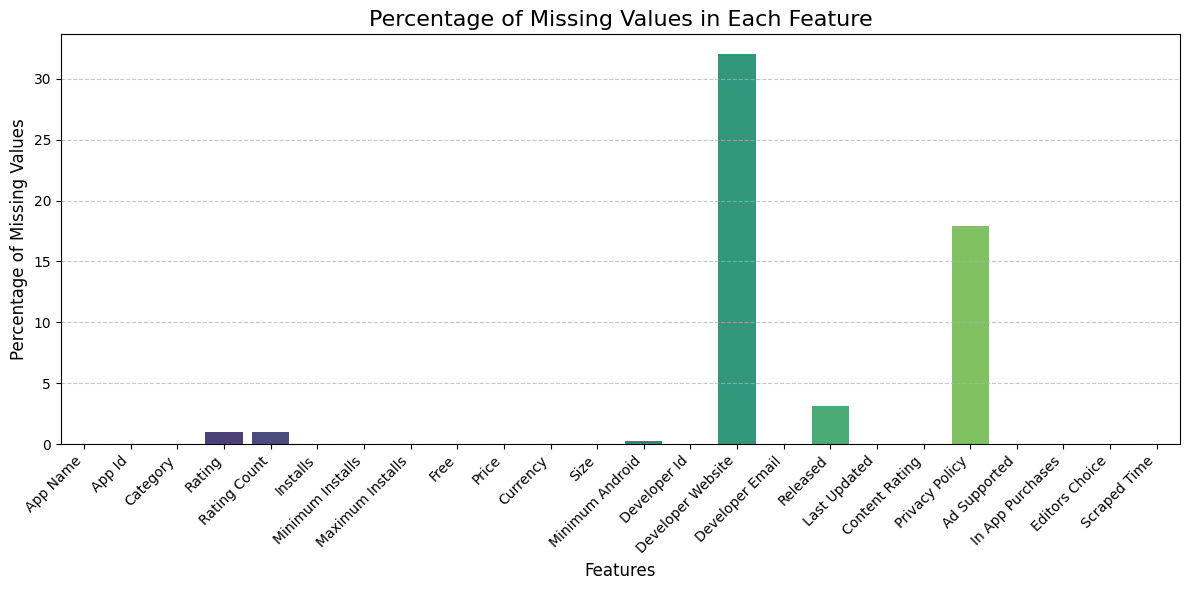

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
null_percentage = (data1.isnull().sum() / len(data1)) * 100

plt.figure(figsize=(12, 6))
sns.barplot(x=null_percentage.index, y=null_percentage, palette="viridis")
plt.title("Percentage of Missing Values in Each Feature", fontsize=16)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Percentage of Missing Values", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The removed columns, including Developer Website, Privacy Policy, Developer Email, In App Purchases, Editors Choice, Ad Supported,'Currency', 'Developer Id' and Scraped Time, exhibited a combination of high null percentages and limited relevance to the primary goals of the Google Play Store EDA. These features, deemed non-critical for the specified analysis, may not contribute substantially to understanding user behavior or app performance. The decision to remove these columns was driven by the aim of conducting a more focused and meaningful EDA, enhancing the quality of insights gained from the dataset.

In [5]:
data2 = data1.drop(['App Id', 'Developer Website', 'Privacy Policy', 'Developer Id', 'Developer Email', 'Currency',
                    'In App Purchases', 'Price', 'Editors Choice', 'Ad Supported', 'Scraped Time'], axis=1)
data2.head()

,App Name,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Size,Minimum Android,Released,Last Updated,Content Rating
0,Gakondo,Adventure,0.0,0.0,10+,10.0,15,True,10M,7.1 and up,"Feb 26, 2020","Feb 26, 2020",Everyone
1,Ampere Battery Info,Tools,4.4,64.0,"5,000+",5000.0,7662,True,2.9M,5.0 and up,"May 21, 2020","May 06, 2021",Everyone
2,Vibook,Productivity,0.0,0.0,50+,50.0,58,True,3.7M,4.0.3 and up,"Aug 9, 2019","Aug 19, 2019",Everyone
3,Smart City Trichy Public Service Vehicles 17UC...,Communication,5.0,5.0,10+,10.0,19,True,1.8M,4.0.3 and up,"Sep 10, 2018","Oct 13, 2018",Everyone
4,GROW.me,Tools,0.0,0.0,100+,100.0,478,True,6.2M,4.1 and up,"Feb 21, 2020","Nov 12, 2018",Everyone


# Imputation in Released Column
For the 'Released' column, essential for app release dates, we've chosen to fill missing values using the mode.
The mode, representing the most frequent date, is a suitable choice for categorical date data.
This ensures that we replace missing values with the most common release date, maintaining data completeness.

In [6]:
released_mode = data2['Released'].mode()[0]
data2['Released'].fillna(released_mode, inplace=True)

# Imputation in 'Rating' and 'Rating Count' Column
To address missing values in 'Rating' we use the median for accuracy, considering the middle value to match the existing data pattern. This method balances extreme values, ensuring reliable results.

In [7]:
data2['Rating'].fillna(data2['Rating'].median(), inplace=True)
data2['Rating Count'].fillna(data2['Rating Count'].median(), inplace=True)

In [8]:
data2.isnull().sum().sort_values(ascending=False)

Minimum Android     6241
Size                 177
Installs             107
Minimum Installs     107
App Name               1
Category               0
Rating                 0
Rating Count           0
Maximum Installs       0
Free                   0
Released               0
Last Updated           0
Content Rating         0
dtype: int64

Convert 'Installs' to Numeric and Impute Missing Values
Converted the 'Installs' column to numeric format by removing the '+' sign, ensuring accurate representation of numerical values for app installations.
Employed the median to fill missing values in the 'Installs', 'Minimum Installs', and 'Maximum Installs' columns.
The median, less influenced by extreme values, ensures a robust imputation strategy, crucial in columns like 'Installs' with widely varying app popularity.
Imputing with the median preserves the original distribution of app installation data, essential for accurate analysis in the 'Installs' columns.

In [9]:
if data2['Installs'].dtype == 'object':
    data2['Installs'] = data2['Installs'].str.replace(',', '').str.extract('(\d+)').astype(float)
data2['Installs'].fillna(0, inplace=True)
data2['Installs'] = data2['Installs'].astype(int)

In [10]:
if data2['Minimum Installs'].dtype == 'object':
    data2['Minimum Installs'] = data2['Minimum Installs'].str.replace(',', '').str.extract('(\d+)').astype(float)
if data2['Maximum Installs'].dtype == 'object':
    data2['Maximum Installs'] = data2['Maximum Installs'].str.replace(',', '').str.extract('(\d+)').astype(float)

# Impute missing values with median
data2['Installs'].fillna(data2['Installs'].median(), inplace=True)
data2['Minimum Installs'].fillna(data2['Minimum Installs'].median(), inplace=True)
data2['Maximum Installs'].fillna(data2['Maximum Installs'].median(), inplace=True)
data2['Installs'].value_counts()

100            419228
1000           374887
10             284577
10000          240494
500            178379
50             161339
5000           134961
100000         101624
5               70181
50000           70105
1               62578
1000000         30711
500000          24779
0               11268
5000000          5941
10000000         5557
50000000          724
100000000         490
500000000          60
1000000000         47
5000000000         14
10000000000         1
Name: Installs, dtype: int64

In [11]:
# Define corrected bins and labels
bins = [0, 100, 1000, 10000, 50000, 100000, 500000, 1000000, 1000000000, 5000000000]
labels = ['0', '100+', '1K+', '50K+', '100K+', '500K+', '1M+', '1B+', '5B+']

data2['Installs_Category'] = pd.cut(data2['Installs'], bins=bins, labels=labels, right=False)
data2['Installs_Category'].value_counts()

100+     597607
0        589943
1K+      509848
50K+     240494
500K+    101624
100K+     70105
1B+       43483
1M+       24779
5B+          47
Name: Installs_Category, dtype: int64

Drop Missing Values in Remaining Columns
Dropping missing values ensures data completeness, integrity, and analytical accuracy. It helps maintain essential columns with complete information, reduces the risk of biased results, and ensures reliable data for accurate analysis and decision-making.

In [12]:
# Drop all missing values in specific columns
data2.dropna(subset=['Minimum Android', 'Content Rating', 'Last Updated','App Name', 'Size'], inplace=True)
data2.dropna(subset=['Installs_Category'],inplace=True)
data2.isnull().sum()

App Name             0
Category             0
Rating               0
Rating Count         0
Installs             0
Minimum Installs     0
Maximum Installs     0
Free                 0
Size                 0
Minimum Android      0
Released             0
Last Updated         0
Content Rating       0
Installs_Category    0
dtype: int64

In [13]:
data3 = data2[data2['App Name'].str.match(r'^[a-zA-Z0-9]+$')]
data3.head()

,App Name,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Size,Minimum Android,Released,Last Updated,Content Rating,Installs_Category
0,Gakondo,Adventure,0.0,0.0,10,10.0,15,True,10M,7.1 and up,"Feb 26, 2020","Feb 26, 2020",Everyone,0
2,Vibook,Productivity,0.0,0.0,50,50.0,58,True,3.7M,4.0.3 and up,"Aug 9, 2019","Aug 19, 2019",Everyone,0
5,IMOCCI,Social,0.0,0.0,50,50.0,89,True,46M,6.0 and up,"Dec 24, 2018","Dec 20, 2019",Teen,0
8,WhatsOpen,Communication,0.0,0.0,10,10.0,18,True,1.3M,4.4 and up,"Jun 16, 2020","Dec 07, 2018",Teen,0
11,Parents,Maps & Navigation,0.0,0.0,100,100.0,330,True,2.7M,4.0 and up,"Jan 10, 2018","Jun 27, 2018",Everyone,100+


In [14]:
catego_columns = data3.select_dtypes(include=['object'])
numeric_columns = data3.select_dtypes(include=['int', 'float'])

In [15]:
for column in catego_columns:
    strange_characters = data3[column].apply(lambda x: not x.isascii() if isinstance(x, str) else False).any()
    if strange_characters:
        print(f'The column "{column}" has strange characters.')
    else:
        print(f'The column "{column}" has no strange characters.')

The column "App Name" has no strange characters.
The column "Category" has no strange characters.
The column "Size" has no strange characters.
The column "Minimum Android" has no strange characters.
The column "Released" has no strange characters.
The column "Last Updated" has no strange characters.
The column "Content Rating" has no strange characters.


In [16]:
def check_empty_spaces(catego_columns):
    empty_spaces = {}
    for column in catego_columns:
        empty_spaces[column] = data3[column].apply(lambda x: isinstance(x, str) and x.strip() == '').sum()
    return empty_spaces
empty_spaces = check_empty_spaces(catego_columns)
for column, recount in empty_spaces.items():
    print(f'Column "{column}" has {recount} values that are empty spaces.')

Column "App Name" has 0 values that are empty spaces.
Column "Category" has 0 values that are empty spaces.
Column "Size" has 0 values that are empty spaces.
Column "Minimum Android" has 0 values that are empty spaces.
Column "Released" has 0 values that are empty spaces.
Column "Last Updated" has 0 values that are empty spaces.
Column "Content Rating" has 0 values that are empty spaces.


In [17]:
data3.insert(0, 'ID', range(1, len(data3) + 1))
df_final = pd.DataFrame(data3)
df_final.head()

,ID,App Name,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Size,Minimum Android,Released,Last Updated,Content Rating,Installs_Category
0,1,Gakondo,Adventure,0.0,0.0,10,10.0,15,True,10M,7.1 and up,"Feb 26, 2020","Feb 26, 2020",Everyone,0
2,2,Vibook,Productivity,0.0,0.0,50,50.0,58,True,3.7M,4.0.3 and up,"Aug 9, 2019","Aug 19, 2019",Everyone,0
5,3,IMOCCI,Social,0.0,0.0,50,50.0,89,True,46M,6.0 and up,"Dec 24, 2018","Dec 20, 2019",Teen,0
8,4,WhatsOpen,Communication,0.0,0.0,10,10.0,18,True,1.3M,4.4 and up,"Jun 16, 2020","Dec 07, 2018",Teen,0
11,5,Parents,Maps & Navigation,0.0,0.0,100,100.0,330,True,2.7M,4.0 and up,"Jan 10, 2018","Jun 27, 2018",Everyone,100+


`Save clean dataset`

In [18]:
# Guardar el DataFrame como un archivo CSV
df_final.to_csv('/content/Google-Playstore-Dataset-Clean.csv', index=False, encoding='utf-8')